In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
import shap
import pickle

from numpy.lib.stride_tricks import sliding_window_view as sliding_window

In [2]:
data = pd.read_csv('train_lagged.csv', low_memory=False, index_col='Unnamed: 0')

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [3]:
test_data = pd.read_csv('test_data.csv', low_memory=False, index_col='Unnamed: 0')

# Feature creating
- closed_duration
- promo_duration
- is_open_tomorrow

In [4]:
data = data.sort_values(['Store', 'Date'])
test_data = test_data.sort_values(['Store', 'Date'])

In [5]:
ids = test_data['Id']
closed_ids = test_data.query('Open == 0')['Id']

In [6]:
test_index = test_data.index

In [7]:
test_index

Int64Index([   47,    46,    45,    44,    43,    42,    41,    40,    39,
               38,
            ...
            41049, 41048, 41047, 41046, 41045, 41044, 41043, 41042, 41041,
            41040],
           dtype='int64', length=41088)

In [8]:
data = pd.concat([data, test_data])
data.loc[data['Id'].isnull() == False].head()

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,t-6,t-7,t-8,t-9,t-10,t-11,t-12,t-13,t-14,Id
47,1,6,2015-08-01,NaN,1.0,0,0,1,2015,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40233.0
46,1,7,2015-08-02,NaN,0.0,0,0,1,2015,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39377.0
45,1,1,2015-08-03,NaN,1.0,1,0,1,2015,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38521.0
44,1,2,2015-08-04,NaN,1.0,1,0,1,2015,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37665.0
43,1,3,2015-08-05,NaN,1.0,1,0,1,2015,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36809.0


**Now we have successfully merged our dataframe, so we're going to create some new features**

In [9]:
def duration_list(feature_name, value):
    d_list = []
    
    for store_num in range(1, 1116):
        feature_list = data.query(f'Store == {store_num}')[feature_name].values
        store_dur_list = np.zeros(feature_list.shape[0])

        for i in range(1, feature_list.shape[0]):
            if feature_list[i-1] == value:
                store_dur_list[i] = store_dur_list[i-1] + 1 
        d_list += list(store_dur_list)
        
    return d_list

In [10]:
close_duration_list = duration_list('Open', 0)
open_duration_list = duration_list('Open', 1)

promo_duration_list = duration_list('Promo', 1)
break_duration_list = duration_list('Promo', 0)

In [11]:
data['close_duration'] = close_duration_list
data['open_duration'] = open_duration_list

data['promo_duration'] = promo_duration_list
data['break_duration'] = break_duration_list

In [12]:
tomorrow_list = []

for store_num in range(1, 1116):
    open_values = data.query(f'Store == {store_num}')['Open']
    tomorrow_list = np.concatenate((tomorrow_list, open_values.shift(-1).fillna(1).values))
    
data['is_open_tomorrow'] = tomorrow_list

In [13]:
data, test = data.loc[data['Id'].isnull() == True], \
             data.loc[data['Id'].isnull() == False]

In [14]:
data.groupby(['close_duration'], as_index=False).agg({'Sales':'mean'}).iloc[:8, :]

,close_duration,Sales
0,0.0,5768.615433
1,1.0,5801.759957
2,2.0,5792.873441
3,3.0,5165.292929
4,4.0,6091.290323
5,5.0,5581.622222
6,6.0,5698.164706
7,7.0,5437.939759


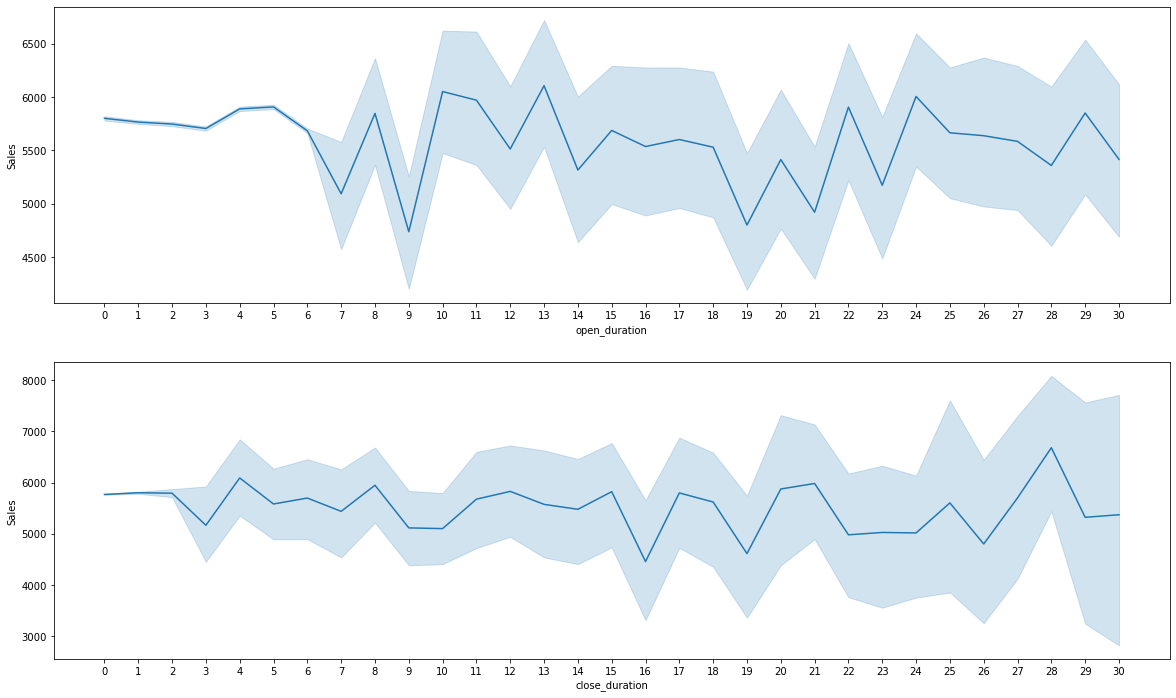

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(20, 12))

sns.lineplot(data=data.query('open_duration < 31'), 
             x='open_duration', y='Sales', ax=axes[0]);
sns.lineplot(data=data.query('close_duration < 31'), 
             x='close_duration', y='Sales', ax=axes[1]);

axes[0].set_xticks(range(0, 31));
axes[1].set_xticks(range(0, 31));

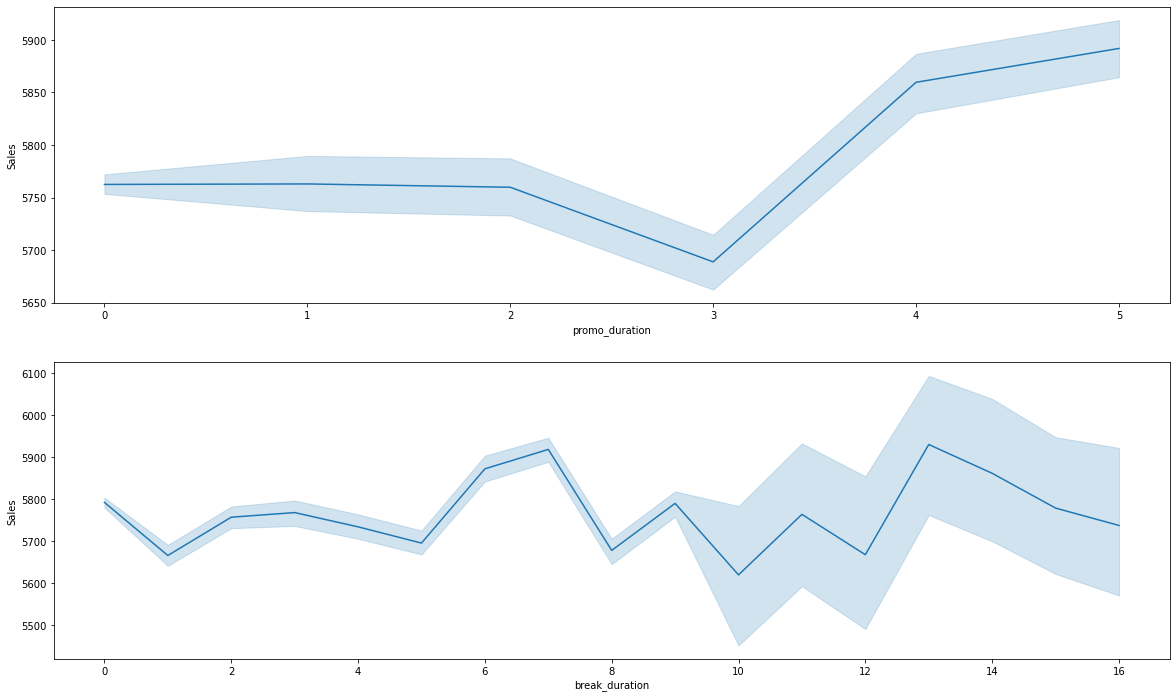

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(20, 12))

sns.lineplot(data=data.query('promo_duration < 31'), 
             x='promo_duration', y='Sales', ax=axes[0]);
sns.lineplot(data=data.query('break_duration < 31'), 
             x='break_duration', y='Sales', ax=axes[1]);

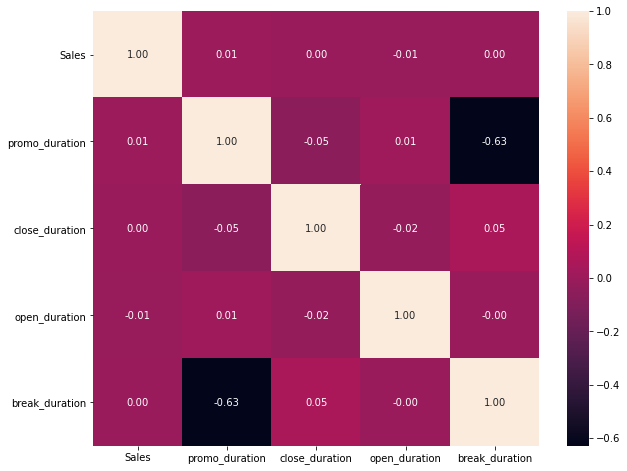

In [17]:
rcParams['figure.figsize'] = 10, 8
check_corr_cols = ['Sales', 'promo_duration', 'close_duration', 'open_duration', 'break_duration']

sns.heatmap(data[check_corr_cols].corr(), annot=True, fmt='.2f')
plt.yticks(rotation='0');

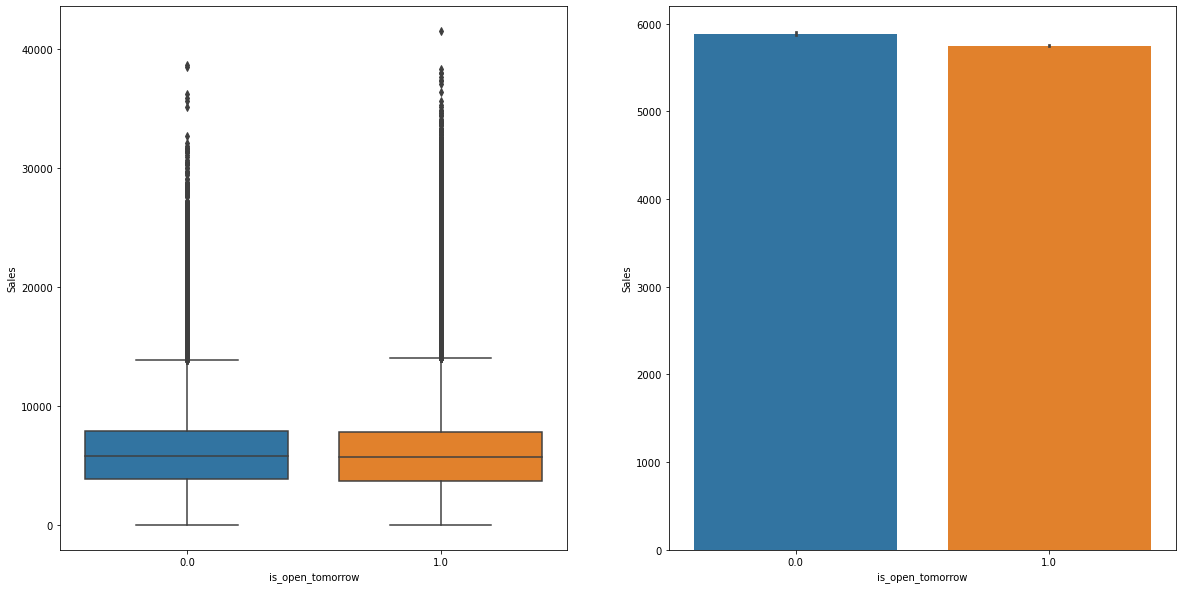

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.boxplot(y='Sales', x='is_open_tomorrow', data=data, ax=axes[0]);
sns.barplot(y='Sales', x='is_open_tomorrow', data=data, ax=axes[1]);

# Training

In [21]:
training_data = data.sort_values(['Date', 'Store']) \
                    .query('Open == 1') \
                    .drop(['Open', 'Id'], axis=1)

In [22]:
mappings_dict = {}

def te_map(data, target_col, feature_col):
    mappings = dict()
    table = data.groupby(feature_col).agg({target_col:'mean'})
    for item_num in range(len(table)):
        mappings.update({table.iloc[item_num, :].name : table.iloc[item_num, :][0]})
    mappings_dict[feature_col] = mappings
    return mappings

def target_encoding(data, target_col):
    for obj_col in data.loc[:, data.dtypes == 'object']:
        if obj_col != 'Date':
            data[obj_col].replace(te_map(data, target_col, obj_col), inplace=True)
    return data

In [23]:
training_data = target_encoding(training_data, 'Sales')

In [24]:
X, y = training_data.drop('Sales', axis=1), training_data['Sales']
X = X.drop(['Date'], axis=1)

In [732]:
X_valid, X_train = training_data.iloc[-40000:, :], training_data.iloc[:-40000, :]

In [733]:
X_train = X_train.drop([col for col in X_train if col.endswith('duration')], axis=1)
X_valid = X_valid.drop([col for col in X_valid if col.endswith('duration')], axis=1)

In [734]:
X_valid, y_valid = X_valid.drop('Sales', axis=1), X_valid['Sales']
X_train, y_train = X_train.drop('Sales', axis=1), X_train['Sales']

X_valid.drop(['Date'], axis=1, inplace=True)
X_train.drop(['Date'], axis=1, inplace=True)

In [574]:
params = {
    "n_estimators" : 1500,
    "booster" : "gbtree",
    "learning_rate": 0.045,
    "max_depth": 12,
    "subsample": 0.8,
    "colsample_bytree": 0.7,
    "random_state": 42,
    "n_jobs": -1
}

In [576]:
model = XGBRegressor(**params).fit(X_train, y_train)

In [577]:
y_pred = model.predict(X_valid)

**RMSPE with all features**: $0.012682469903912684$

**RMSPE without durations**: $0.012500877406066164$

In [581]:
print(f'Rmspe without durations: {rmspe(y_pred, y_valid)}')

Rmspe without durations: 0.012500877406066164


In [584]:
importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['importance'])

In [585]:
importances = importances.sort_values('importance', ascending=False)

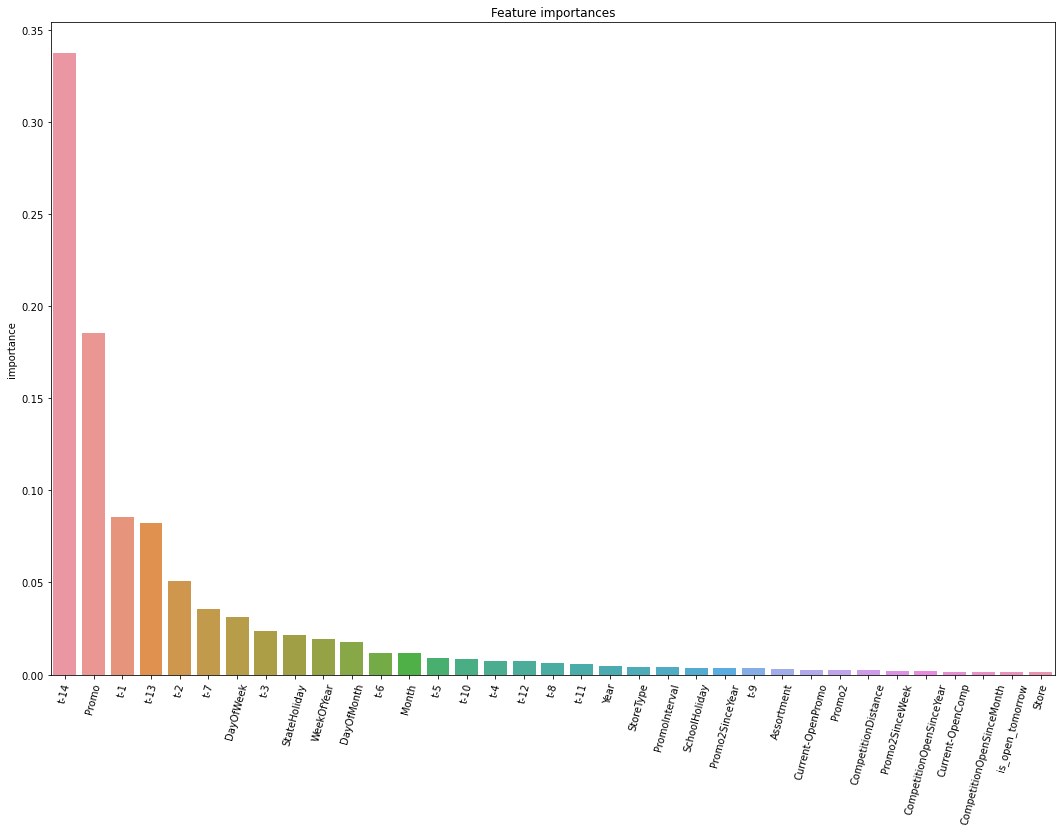

In [586]:
rcParams['figure.figsize'] = 18, 12

sns.barplot(x=importances.index, y=importances['importance']);
plt.xticks(rotation='75');
plt.title('Feature importances');

In [49]:
def rmspe(y_pr, y_valid) -> float:
    n = len(y_valid)
    return np.sum(((y_pr - y_valid) / y_valid) ** 2) / n

# SHAP

In [23]:
explainer = shap.Explainer(model)
shap_values = explainer(X.iloc[-1115*7 * 2:, :])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


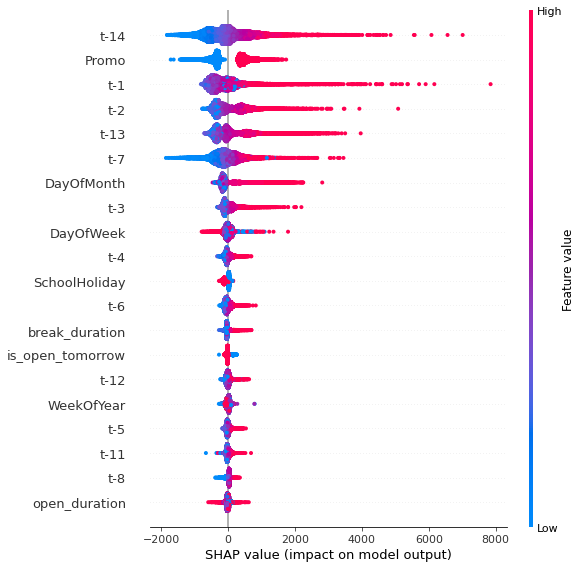

In [24]:
shap.summary_plot(shap_values)

Since we have no doubt that our lags are **very** important, we'll remove them from our model to see how our new features influence on answer

In [28]:
filter_cols = [col for col in X.columns if not col.startswith('t-')]
X_wo_lags = X[filter_cols]

In [30]:
model_wo_lags = XGBRegressor(**params).fit(X_wo_lags, y)

In [36]:
explainer_2 = shap.Explainer(model_wo_lags)
shap_values_2 = explainer(X_wo_lags.iloc[-1115*7 * 4:, :])

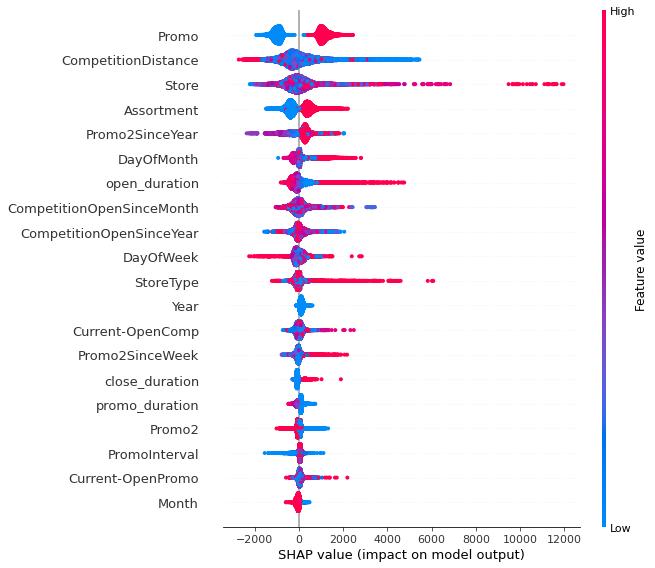

In [37]:
shap.summary_plot(shap_values_2)

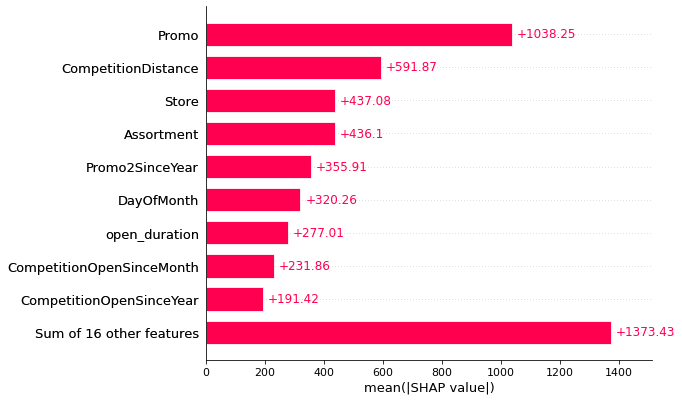

In [56]:
shap.plots.bar(shap_values)

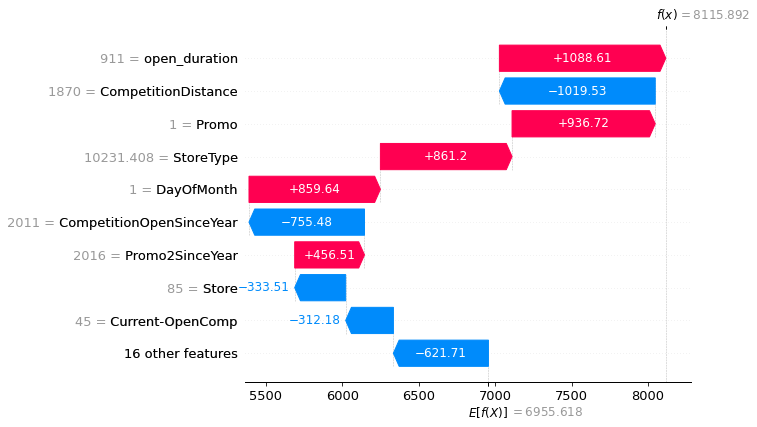

In [42]:
shap.plots.waterfall(shap_values_2[1116])

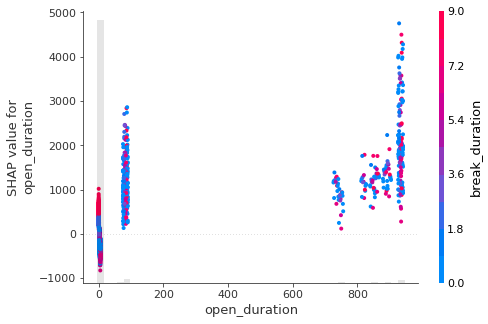

In [53]:
shap.plots.scatter(shap_values[:, "open_duration"], color=shap_values)

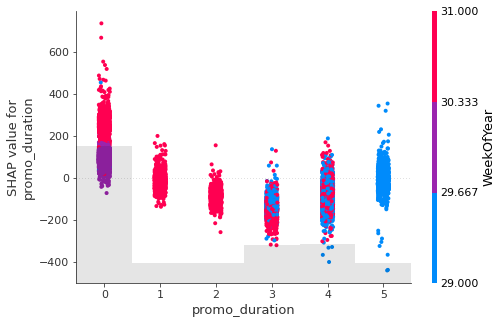

In [54]:
shap.plots.scatter(shap_values[:, "promo_duration"], color=shap_values)

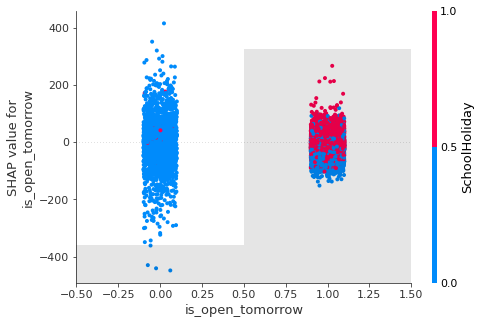

In [55]:
shap.plots.scatter(shap_values[:, "is_open_tomorrow"], color=shap_values)

# Predicting for kaggle

In [25]:
params = {
    "n_estimators" : 10,
    "booster" : "gbtree",
    "learning_rate": 0.3,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.7,
    "random_state": 42,
    "n_jobs": -1
}

In [26]:
model = XGBRegressor(**params).fit(X, y)

In [27]:
sales_table = pd.pivot(data=training_data, index='Date',
                             columns='Store', values=['Sales']).fillna(0)
sales_table.columns = [i for i in range(1, 1116)]

In [28]:
required_stores = [col for col in sales_table.columns if col in test['Store'].unique()]
sales_table = sales_table[required_stores]

In [29]:
sales_table = sales_table.reset_index()
sales_table['Date'] = pd.to_datetime(sales_table['Date'])
sales_table = sales_table.set_index('Date')

In [31]:
sales_table.tail()

,1,3,7,8,9,10,11,12,13,14,...,1104,1105,1106,1107,1109,1111,1112,1113,1114,1115
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-27,6102.0,8107.0,14869.0,8739.0,10649.0,7212.0,8796.0,10227.0,7926.0,6614.0,...,7853.0,7260.0,7042.0,11221.0,8082.0,7742.0,14383.0,7582.0,26720.0,10712.0
2015-07-28,5011.0,8864.0,12342.0,6717.0,8751.0,6140.0,6938.0,8822.0,6819.0,5957.0,...,6134.0,5992.0,6037.0,9533.0,6478.0,6793.0,9583.0,6468.0,25518.0,8093.0
2015-07-29,4782.0,7610.0,12074.0,7029.0,7776.0,5524.0,8378.0,9236.0,6648.0,5412.0,...,5275.0,5662.0,5536.0,8168.0,6212.0,4907.0,9179.0,6640.0,25840.0,7661.0
2015-07-30,5020.0,8977.0,11560.0,8420.0,7539.0,6186.0,7361.0,7996.0,7648.0,5672.0,...,5989.0,6062.0,5560.0,8198.0,5520.0,5263.0,9652.0,7491.0,24395.0,8405.0
2015-07-31,5263.0,8314.0,15344.0,8492.0,8565.0,7185.0,10457.0,8959.0,8821.0,6544.0,...,6878.0,7994.0,5901.0,9433.0,5263.0,5723.0,9626.0,7289.0,27508.0,8680.0


In [32]:
test['Date'] = pd.to_datetime(test['Date'])

In [33]:
for col in mappings_dict:
    test[col] = test[col].map(mappings_dict[col])

In [34]:
predictions = {}

In [36]:
for day in test['Date'].unique():
    daily_test = test[test['Date'] == day]
    
    for timestamp in range(1, 15):
        lag_day = day - pd.to_timedelta(timestamp, unit='d')
        daily_test['t-' + str(timestamp)] = sales_table.loc[lag_day].values
        
    predicting_samples = daily_test.query('Open == 1')
    closed_samples = daily_test.query('Open != 1')
    
    #Feature drop
    predicting_samples = predicting_samples.drop(['Date', 'Open', 'Sales', 'Id'], axis=1)
        
    #Predicting
    daily_prediction = model.predict(predicting_samples)
    
    #Updating sales_table
    prediction_store_dict = dict(zip(predicting_samples['Store'].values, daily_prediction))
    zeros_store_dict = dict(zip(closed_samples['Store'].values, np.zeros(closed_samples.shape[0])))
    prediction_store_dict.update(zeros_store_dict)

    sales_table.loc[day] = prediction_store_dict
    
    #Updating predictions
    sorted_predicted_sales = dict(sorted(prediction_store_dict.items())).values()
    predictions.update(dict(zip(daily_test['Id'].values, sorted_predicted_sales)))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [38]:
predictions_df = pd.DataFrame.from_records([predictions]).T
predictions_df = predictions_df.sort_index() \
                               .reset_index() \
                               .rename(columns={'index':'Id', 0:'Sales'})
predictions_df = predictions_df.astype({'Id': int}, errors='raise') 

In [39]:
predictions_df = predictions_df.set_index('Id')

In [40]:
predictions_df

,Sales
Id,
1,4375.112793
2,6003.356934
3,8994.447266
4,6003.356934
5,6404.310059
...,...
41084,2396.285645
41085,6762.445312
41086,5250.248535


In [41]:
predictions_df

,Sales
Id,
1,4393.166504
2,7253.489746
3,10483.500977
4,6903.435059
5,6624.537109
...,...
41084,2427.193604
41085,6886.520020
41086,5829.818359


In [40]:
predictions_df.to_csv('Rossmann_submission.csv')